# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [16]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [2]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-01-21 08:11:15--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.120
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  47.7MB/s    in 25s     

2023-01-21 08:11:50 (43.6 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [17]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = "project_3"

## Webdataset Creation and store into S3
* I used a webdataset to upload data into S3 bucket; in this way I can retrieve dataset and then create a dataloader for efficeint training

In [2]:
!pip install webdataset

  Using cached webdataset-0.2.31-py3-none-any.whl (50 kB)
  Using cached braceexpand-0.1.7-py2.py3-none-any.whl (5.9 kB)


In [13]:
import webdataset as wds
import torchvision
from glob import glob

In [9]:
train_folder = './dogImages/train'
# Create a list of all files in all folders/classes
basenames = glob(train_folder + '/**/*.jpg')

In [18]:
test_folder = './dogImages/test'
basenames_test = glob(test_folder + '/**/*.jpg')

In [25]:
# Extract the class type from folder name
def lookup_cls(basename):
  return basename.split('/')[-2].split('.')[0].encode('ascii')

In [26]:
# Creazione archivio tar con immagini e classi
def create_webdataset(basenames, output_path):
    #sink = wds.TarWriter('./dogImages_dataset.tar')
    sink = wds.TarWriter(output_path)
    for basename in basenames:
        with open(f"{basename}", "rb") as stream:
            image = stream.read()
        cls = lookup_cls(basename)
        sample = {
            "__key__": basename,
            "input.jpg": image,
            "target.cls": cls
        }
        sink.write(sample)
    sink.close()

In [ ]:
# Create webdataset for train
create_webdataset(basenames=basenames, output_path='./dogImages_dataset.tar')

In [27]:
# Create webdataset for test
create_webdataset(basenames=basenames_test, output_path='./dogImages_dataset_test.tar')

In [18]:
# Upload tar webdataset into S3
inputs = sagemaker_session.upload_data(path='./dogImages_dataset.tar', bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-265345480326/project_3/dogImages_dataset.tar


In [103]:
#inputs = sagemaker_session.upload_data(path='./dogImages/', bucket=bucket, key_prefix=prefix)

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-265345480326/project_3


## Class type extraction

* I get in list_classe variable all the classes in train set
* I get in list_train_files variable all the path file in train set

In [100]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from glob import glob
%matplotlib inline

In [6]:
local_path_train = './dogImages/train/'
local_path_test = './dogImages/test/'

In [7]:
list_classes = os.listdir(local_path_train)

In [8]:
list_train_files = glob(local_path_train+'/**/*.jpg', recursive=True)

In [9]:
print(list_classes)

['114.Otterhound', '110.Norwegian_lundehund', '127.Silky_terrier', '091.Japanese_chin', '095.Kuvasz', '061.English_cocker_spaniel', '043.Canaan_dog', '131.Wirehaired_pointing_griffon', '124.Poodle', '087.Irish_terrier', '053.Cocker_spaniel', '064.English_toy_spaniel', '105.Neapolitan_mastiff', '032.Boston_terrier', '017.Bearded_collie', '094.Komondor', '003.Airedale_terrier', '084.Icelandic_sheepdog', '122.Pointer', '098.Leonberger', '125.Portuguese_water_dog', '009.American_water_spaniel', '058.Dandie_dinmont_terrier', '115.Papillon', '006.American_eskimo_dog', '041.Bullmastiff', '085.Irish_red_and_white_setter', '081.Greyhound', '004.Akita', '103.Mastiff', '044.Cane_corso', '118.Pembroke_welsh_corgi', '013.Australian_terrier', '117.Pekingese', '002.Afghan_hound', '025.Black_and_tan_coonhound', '129.Tibetan_mastiff', '093.Kerry_blue_terrier', '023.Bernese_mountain_dog', '070.German_pinscher', '052.Clumber_spaniel', '048.Chihuahua', '088.Irish_water_spaniel', '050.Chinese_shar-pei', '1

In [11]:
list_classes_elab = [x.split('.') for x in list_classes]

In [12]:
df_class = pd.DataFrame(list_classes_elab, columns=['class_id','class_descr'])
#df_class = df_class.sort_values(by=['class_id'])


In [13]:
df_class.head()

,class_id,class_descr
0,114,Otterhound
1,110,Norwegian_lundehund
2,127,Silky_terrier
3,091,Japanese_chin
4,095,Kuvasz


In [14]:
# Add the column num files for each class
num_files = []
for i, classe in enumerate(list_classes):
    num_files.append(len(os.listdir(local_path_train + classe)))

In [93]:
df_class['num_files'] = num_files

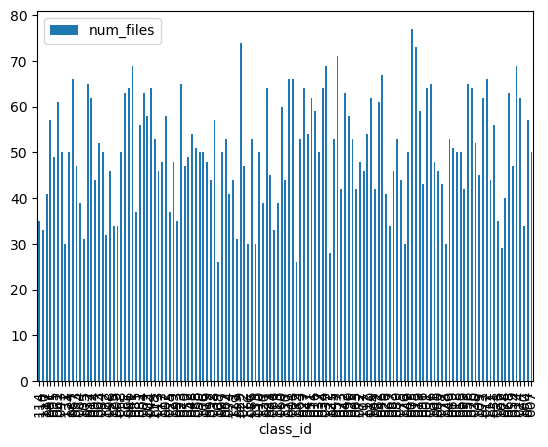

In [98]:
df_class.plot.bar(x='class_id', y='num_files')

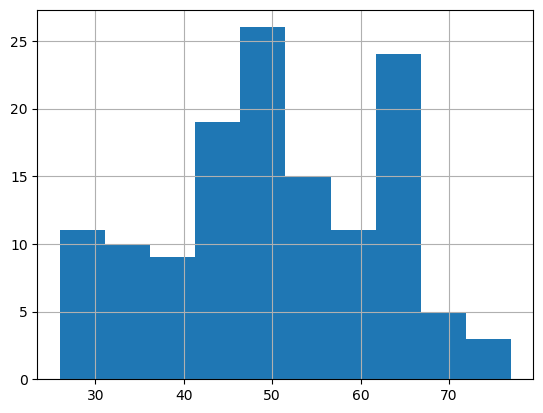

In [99]:
df_class['num_files'].hist()

## Data visualization

* Random visualization of a grid 3x3 of images

In [15]:
random_imgs = np.random.randint(0, len(list_train_files), 9)

In [16]:
list_train_files[random_imgs[0]]

'./dogImages/train/055.Curly-coated_retriever/Curly-coated_retriever_03880.jpg'

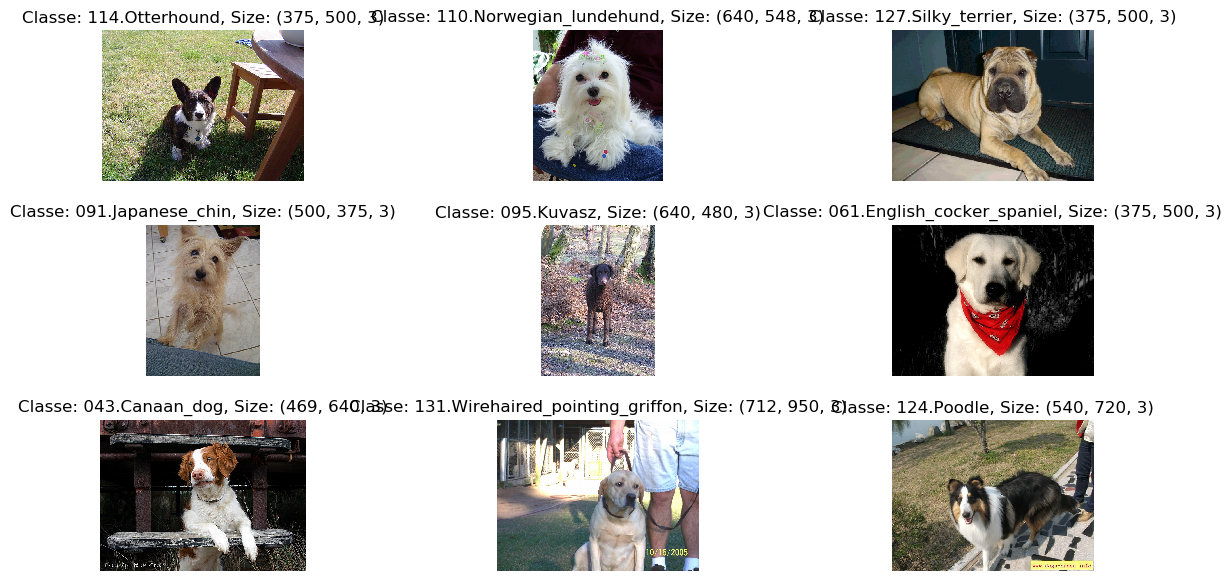

In [18]:
fig, axs = plt.subplots(3,3, figsize=(12,6))
plt.tight_layout()
axs = axs.ravel()
random_imgs = np.random.randint(0, len(list_train_files), 9)

for i, ax in enumerate(axs):
    img = mpimg.imread(list_train_files[random_imgs[i]])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Classe: {list_classes[i]}, Size: {img.shape}')

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [42]:
!pip install webdataset

Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.3 MB/s eta 0:00:00


In [59]:
!pip install torchdata

Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 35.0 MB/s eta 0:00:0000:0100:01


### Test: Dataloader creation from S3 bucket
link: 
* https://towardsdatascience.com/training-in-pytorch-from-amazon-s3-6156d5342d1
* https://docs.aws.amazon.com/lookout-for-vision/latest/developer-guide/create-dataset-s3.html
* https://aws.amazon.com/it/blogs/machine-learning/announcing-the-amazon-s3-plugin-for-pytorch/

In [2]:
!pip install webdataset

  Using cached webdataset-0.2.31-py3-none-any.whl (50 kB)
  Using cached braceexpand-0.1.7-py2.py3-none-any.whl (5.9 kB)


In [20]:
# Test Create Dataloader from S3 bucket
import imageio
import io
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
import webdataset as wds

In [7]:
# Definisce una map su ogni elemento Resize immagine
def preprocess(sample):
    image, cls = sample
    #image = T.Resize(size=(224,224))(T.ToTensor()(image))
    image = T.ToTensor()(image)
    image = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
    image = T.Resize(size=(224,224))(image)
    label = cls
    
    return 1-image, label

In [29]:
# Carica un archivio TAR dal cloud, tipo IterableDataset

#url = "https://sagemaker-us-east-1-265345480326.s3.amazonaws.com/project_3/dogImages_dataset.tar"
url = "./dogImages_dataset.tar"

dataset = wds.WebDataset(url).shuffle(1000).decode("rgb").to_tuple("jpg.input.jpg", "jpg.target.cls").map(preprocess)
dataset = dataset.batched(16)

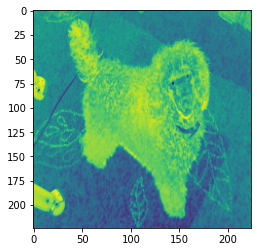

In [30]:
# Recupero il primo campione del dataset
tmp = next(iter(dataset))
# Mostra immagine
plt.imshow(tmp[0][0,0,:,:])

In [10]:
# Loader definition
loader = wds.WebLoader(dataset, num_workers=2, batch_size=None)
loader = loader.unbatched().shuffle(1000).batched(12)

In [37]:
# Visualizzare il loader
batch = next(iter(loader))
batch[0].shape, batch[1]

(torch.Size([12, 3, 224, 224]),
 tensor([ 91,  61,  91, 110,  61,  95,  95, 114, 127,  91,  95,  95]))

In [35]:
def create_loader(url, batch_size):
    '''
    This is an optional function that you may or may not need to implement
    depending on whether you need to use data loaders or not
    '''
    # Create Dataset from tar archive
    dataset = wds.WebDataset(url).shuffle(1000).decode("rgb").to_tuple("jpg.input.jpg", "jpg.target.cls").map(preprocess)
    dataset = dataset.batched(16)
    
    # Create Loader
    loader = wds.WebLoader(dataset, num_workers=2, batch_size=None)
    loader = loader.unbatched().shuffle(1000).batched(batch_size)
    
    return loader

In [36]:
loader_example = create_loader(url, 32)

In [41]:
# Visualizzare il loader
for batch_idx, (data, target) in enumerate(loader_example):
    print(data.shape, target)
    break

torch.Size([32, 3, 224, 224]) tensor([ 32,   6,   2,  44,  61,  91,  91,   6,  94, 129,   6,  44,   4,  70,
         44,  61, 131,  32, 105, 133,  98, 114, 114,  85, 124,  74,  53,  25,
         81,   4,  95,  17])


In [17]:
from torchvision.datasets import ImageFolder

In [37]:
training_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [38]:
train_dataset = torchvision.datasets.ImageFolder(root='./dogImages/train', transform=training_transform)

In [39]:
# Recupero il primo campione del dataset
tmp = next(iter(train_dataset))
# Mostra immagine
print(tmp[1])

0


In [40]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

In [41]:
# Visualizzare il loader
batch = next(iter(trainloader))
batch[0].shape

torch.Size([16, 3, 224, 224])

## Fine tuning testing

In [48]:
!pip install torch

In [43]:
from torchvision import models
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [44]:
for param in model.parameters():
    param.requires_grad = False

In [50]:
import torch
from torch import nn

num_features=model.fc.in_features
print(num_features)
model.fc = nn.Sequential(nn.Linear(num_features, 133))

2048


## Definition of hpo, tuner and estimantor

In [2]:
import sagemaker

In [3]:
# Instatiate the tuner
from sagemaker.tuner import (
    ContinuousParameter, 
    CategoricalParameter, 
    HyperparameterTuner
)

In [4]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = "project_3"

In [5]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

In [6]:
# Import Pytorch estimator
from sagemaker.pytorch import PyTorch

In [7]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [8]:
#TODO: Create estimators for your HPs

# TODO: Your estimator here
estimator = PyTorch(
    entry_point='hpo.py',
    role=role,
    py_version='py36',
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.m5.large'
)

In [9]:
# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [13]:
# TODO: Fit your HP Tuner
tuner.fit(wait=True) # TODO: Remember to include your data channels______

.................................................................................*


UnexpectedStatusException: Error for HyperParameterTuning job pytorch-training-230124-0537: Failed. Reason: No objective metrics found after running 4 training jobs. Please ensure that the custom algorithm is emitting the objective metric as defined by the regular expression provided.

In [ ]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

estimator = # TODO: Your estimator here

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()